# Facial Expression Recognition Project

## Library Installations and Imports

In [0]:
!pip install -U -q PyDrive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydot

import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical
from keras import backend as K


### Confirm Tensorflow and GPU Support

In [6]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18034026762059082058, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 356122624
 locality {
   bus_id: 1
 }
 incarnation: 6676977091435139987
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# previous token was 4/AACID65Nxa7BHDHpZA-B8KTFCD_ctqRXJjozgUjW5rirIQVTFwJzE3E

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [15]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 48, 48, 1)
	Testing: 	<class 'numpy.uint8'>	(3589, 48, 48, 1)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
#np.save('img_train.npy', img_train)
#np.save('lbl_train.npy', lbl_train)
#np.save('img_test.npy', img_test)
#np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

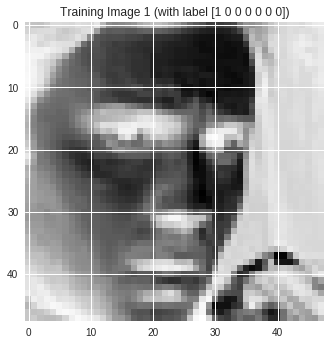

In [17]:
plt.imshow(np.reshape(img_train[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

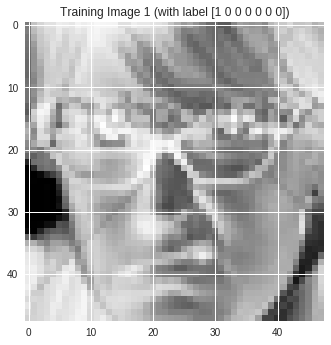

In [18]:
plt.imshow(np.reshape(img_test[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model


In [0]:
model = Sequential()

### Phase 1
- Locally-Connected Convlutional Filtering Phase.
  - The locally-connected layer works similarly to the traditional 2D convolutional layer, except that weights are unshared, that is, a different set of filters is applied at each different patch of the input.
- **Ouput Filters: 8**
- **Kernal Size: 4x4**
- **Stride: 1 (default)**
- **Non-Active Padding**

In [22]:
outputFilters = 8
kernelSize = 4

model.add(LocallyConnected2D(outputFilters, kernelSize, padding='valid', 
                             activation='relu', input_shape=img_train[0].shape))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_2 (Local (None, 45, 45, 8)         275400    
Total params: 275,400
Trainable params: 275,400
Non-trainable params: 0
_________________________________________________________________


### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 32**
- **Stride: 1 (default)**
- **Active Padding**

In [23]:
outputFilters = 32
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_2 (Local (None, 45, 45, 8)         275400    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        2336      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
Total params: 296,232
Trainable params: 296,232
Non-trainable params: 0
_________________________________________________________________


### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 64**
- **Stride: 1 (default)**
- **Active Padding**

In [24]:
outputFilters = 64
kernelSize = 3 

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_2 (Local (None, 45, 45, 8)         275400    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        2336      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Level 3

- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 128
- Padding protocol: Output is same dimensions as original image.

In [25]:
outputFilters = 128
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_2 (Local (None, 45, 45, 8)         275400    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        2336      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Dense Layers

In [26]:
layerSize = 64
dropoutRate = 0.5

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_2 (Local (None, 45, 45, 8)         275400    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        2336      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Show Model Structure

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

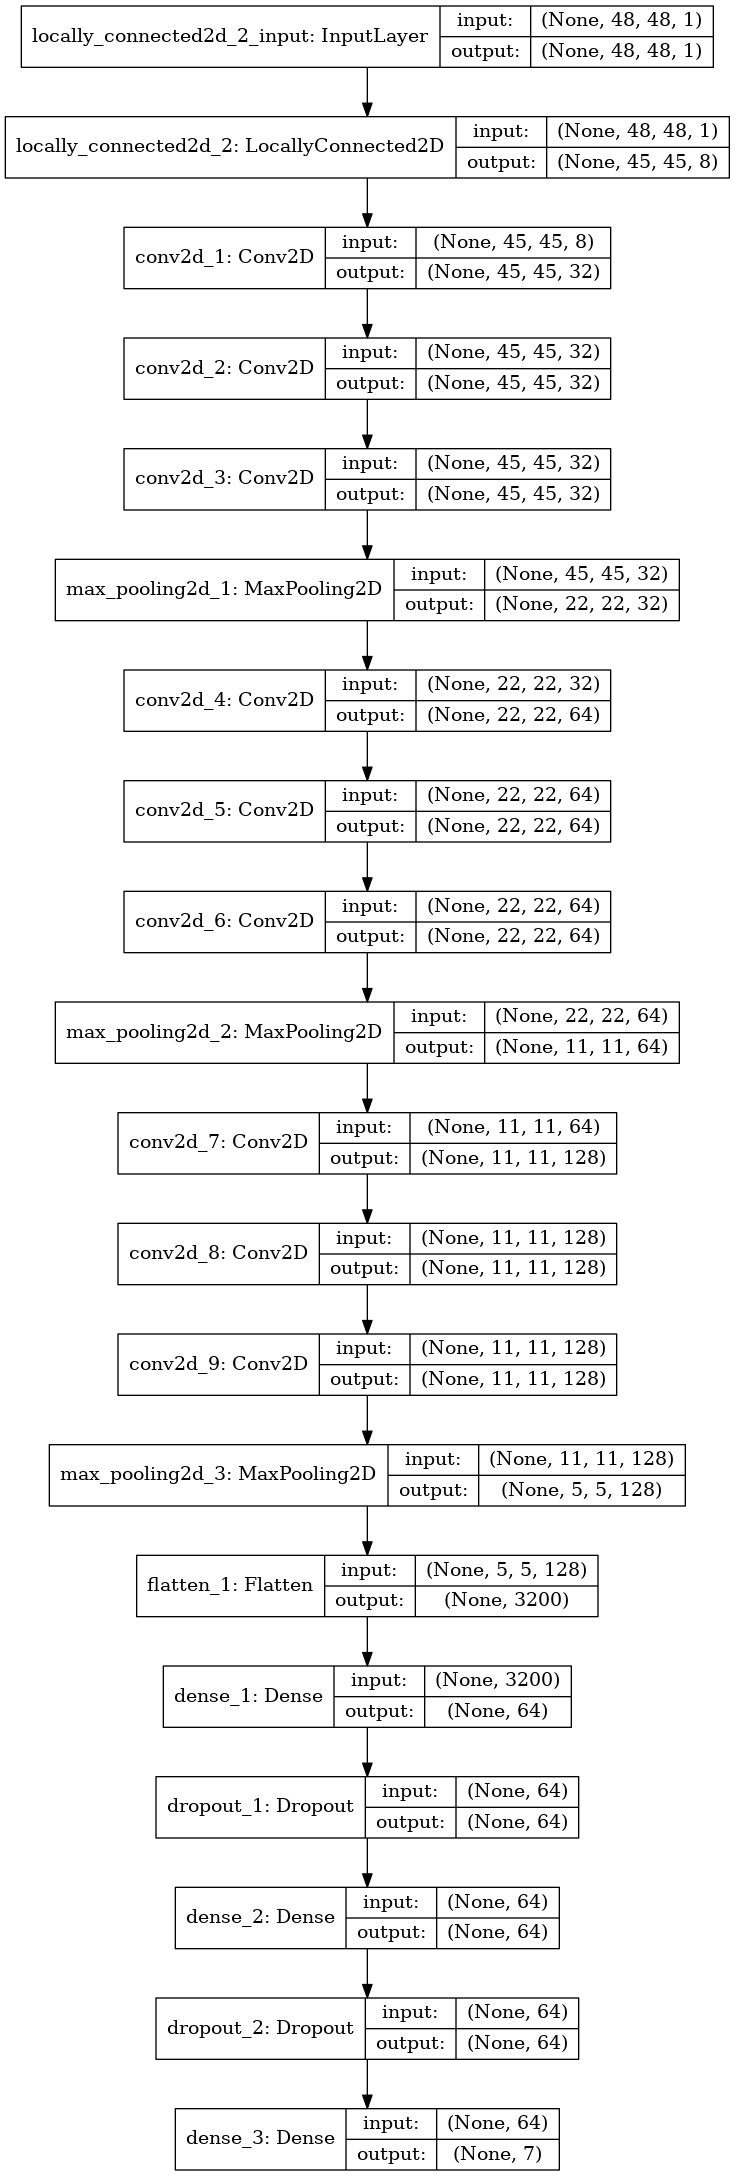

In [28]:
from IPython.display import Image
Image(filename='model.png') 

## Compile, Train, and Evaluate the Model

In [30]:
batchSize = 128
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,
                            validation_split=0.3, 
                            callbacks=[early_stopping], 
                            shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']
print("Done Training: ")
print('Final Training Accuracy: ', trainingAccuracy[-1])
print('Final Validation Accuracy: ', validationAccuracy[-1])
print('Overfit Ratio: ', validationAccuracy[-1]/trainingAccuracy[-1])

metrics = model.evaluate(img_test, lbl_test, batch_size=batchSize, verbose=1)
print('Evaluation Loss: ', metrics[0])
print('Evaluation Accuracy: ', metrics[1])

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 56s 3ms/step - loss: 0.9641 - acc: 0.6417 - val_loss: 1.8936 - val_acc: 0.4331
Epoch 2/50
20096/20096 [==============================] - 29s 1ms/step - loss: 0.9208 - acc: 0.6645 - val_loss: 1.9948 - val_acc: 0.4312
Epoch 3/50
10112/20096 [==============>...............] - ETA: 12s - loss: 0.8696 - acc: 0.6725

20096/20096 [==============================] - 29s 1ms/step - loss: 0.8940 - acc: 0.6662 - val_loss: 1.9458 - val_acc: 0.4292
Epoch 4/50
20096/20096 [==============================] - 29s 1ms/step - loss: 0.9079 - acc: 0.6687 - val_loss: 1.9330 - val_acc: 0.4313
Epoch 5/50
20096/20096 [==============================] - 29s 1ms/step - loss: 0.8547 - acc: 0.6856 - val_loss: 2.0654 - val_acc: 0.4367
Epoch 6/50
  640/20096 [..............................] - ETA: 24s - loss: 0.6918 - acc: 0.7578

20096/20096 [==============================] - 29s 1ms/step - loss: 0.8459 - acc: 0.6893 - val_loss: 2.0177 - val_acc: 0.4274
Epoch 00006: early stopping
Done Training: 
Final Training Accuracy:  0.6892914012738853
Final Validation Accuracy:  0.42737722046682813
Overfit Ratio:  0.6200240125975583
3589/3589 [==============================] - 2s 581us/step
Evaluation Loss:  1.9509493886145683
Evaluation Accuracy:  0.44218445250203464
